# Computing the optimal path for finding Waldo

This notebook provides the methodology and code used in the blog post, [Here’s Waldo: Computing the optimal search strategy for finding Waldo](http://www.randalolson.com/2015/02/03/heres-waldo-computing-the-optimal-search-strategy-for-finding-waldo/).

### Notebook by [Abduulah J. Almukallaf]

Please see the [repository README file](https://github.com/Abndo76/Data-Analysis-and-ML-Projects#license) for the licenses and usage terms for the instructional material and code in this notebook. In general, I have licensed this material so that it is as widely useable and shareable as possible.


### Read the data into a pandas DataFrame

Since we already have all 68 locations of Waldo from [Slate](http://www.slate.com/content/dam/slate/articles/arts/culturebox/2013/11/131111_heresWaldo920_1.jpg.CROP.original-original.jpg), we can jump right into analyzing them. 

In [2]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import random
import math

sb.set_style("white")
plt.style.use("tableau10")

wheres_waldo_locations = pd.read_csv("wheres-waldo-locations.csv")
wheres_waldo_locations.describe()

,Book,Page,X,Y
count,68.000000,68.000000,68.000000,68.000000
mean,3.514706,6.058824,6.700776,3.875306
std,1.856756,3.411492,3.703276,1.941349
min,1.000000,1.000000,0.625000,0.333333
25%,2.000000,3.000000,3.513889,2.250000
50%,3.000000,6.000000,6.694444,3.927083
75%,5.000000,9.000000,10.062500,5.291667
max,7.000000,12.000000,12.444444,7.708333


### Plot the dots according to the book they came from

The first basic visualization that we can make is to plot all of the points according to the book that they came from.

The dashed line in the center represents the crease of the book, as "Where's Waldo" illustrations always stretched over two pages.

''

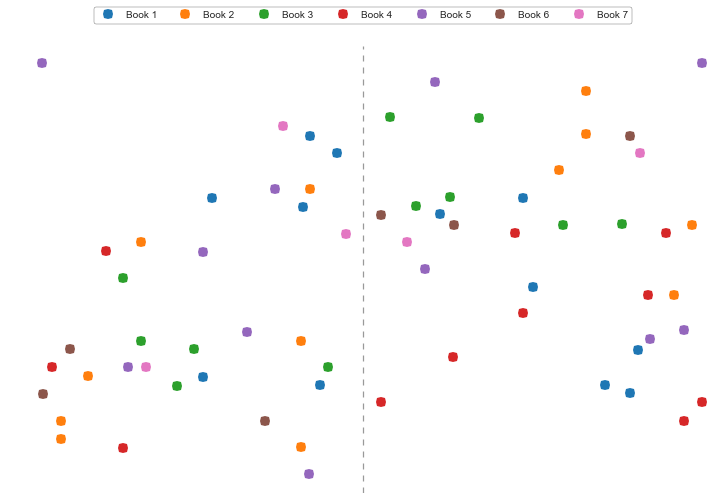

In [2]:
plt.figure(figsize=(12.75, 8))
plt.plot([6.375, 6.375], [0, 8], "--", color="black", alpha=0.4, lw=1.25)

for book, group in wheres_waldo_locations.groupby("Book"):
    plt.plot(group.X, group.Y, "o", label="Book %d" % (book))

plt.xlim(0, 12.75)
plt.ylim(0, 8)
plt.xticks([])
plt.yticks([])
plt.legend(loc="upper center", ncol=7, frameon=True, fancybox=True, bbox_to_anchor=(0.5, 1.1))
;

### Kernel Density Estimation

Next, we can use the [Seaborn library](http://stanford.edu/~mwaskom/software/seaborn/examples/index.html) to perform a [kernel density estimation](http://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) of the points.

A KDE will show us Waldo's hot spots, i.e., where he's most likely to appear.

''

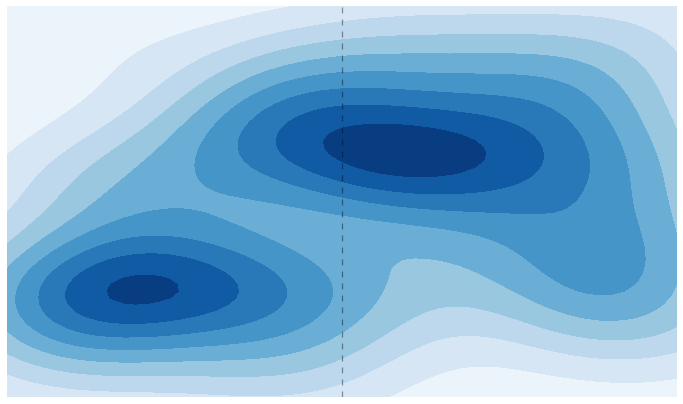

In [3]:
sb.kdeplot(wheres_waldo_locations.X, wheres_waldo_locations.Y, shade=True, cmap="Blues")
plt.plot([6.375, 6.375], [0, 8], "--", color="black", alpha=0.4, lw=1.25)
plt.xlim(0, 12.75)
plt.ylim(0, 8)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
;

### Genetic Algorithm

Now on to the real fun! I decided to approach this problem as a [traveling salesman problem](http://en.wikipedia.org/wiki/Travelling_salesman_problem): We need to check every possible location that Waldo could be at while taking as little time as possible. That means we need to cover as much ground as possible without any backtracking.

In computer terms, that means we’re making a list of all 68 points that Waldo could be at, then sorting them based on the order that we’re going to visit them. We can use a [genetic algorithm](http://en.wikipedia.org/wiki/Genetic_algorithm) (GA) to try out hundreds of possible arrangements and continually build upon the best ones. Note that because GAs are stochastic, the end result will not always be the same each time you run it.

#### Reorganize the DataFrame Xs and Ys into a lookup table

Constantly looking up values in a DataFrame is quite slow, so it's better to use a dictionary.

In [4]:
waldo_location_map = {}

for i, record in wheres_waldo_locations.iterrows():
    key = "B%dP%d" % (record.Book, record.Page)
    waldo_location_map[key] = (record.X, record.Y)

#### Basic functions for the Genetic Algorithm

In [5]:
def calculate_distance(x1, y1, x2, y2):
    """
        Returns the Euclidean distance between points (x1, y1) and (x2, y2)
    """
    return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def compute_fitness(solution):
    """
        Computes the distance that the Waldo-seeking solution covers.
        
        Lower distance is better, so the GA should try to minimize this function.
    """
    solution_fitness = 0.0
    
    for index in range(1, len(solution)):
        w1 = solution[index]
        w2 = solution[index - 1]
        solution_fitness += calculate_distance(waldo_location_map[w1][0], waldo_location_map[w1][1],
                                               waldo_location_map[w2][0], waldo_location_map[w2][1])
        
    return solution_fitness

def generate_random_agent():
    """
        Creates a random Waldo-seeking path.
    """
    new_random_agent = waldo_location_map.keys()
    random.shuffle(new_random_agent)
    return tuple(new_random_agent)

def mutate_agent(agent_genome, max_mutations=3):
    """
        Applies 1 - `max_mutations` point mutations to the given Waldo-seeking path.
        
        A point mutation swaps the order of two locations in the Waldo-seeking path.
    """
    agent_genome = list(agent_genome)
    num_mutations = random.randint(1, max_mutations)
    
    for mutation in range(num_mutations):
        swap_index1 = random.randint(0, len(agent_genome) - 1)
        swap_index2 = swap_index1

        while swap_index1 == swap_index2:
            swap_index2 = random.randint(0, len(agent_genome) - 1)

        agent_genome[swap_index1], agent_genome[swap_index2] = agent_genome[swap_index2], agent_genome[swap_index1]
            
    return tuple(agent_genome)

def shuffle_mutation(agent_genome):
    """
        Applies a single shuffle mutation to the given Waldo-seeking path.
        
        A shuffle mutation takes a random sub-section of the path and moves it to
        another location in the path.
    """
    agent_genome = list(agent_genome)
    
    start_index = random.randint(0, len(agent_genome) - 1)
    length = random.randint(2, 20)
    
    genome_subset = agent_genome[start_index:start_index + length]
    agent_genome = agent_genome[:start_index] + agent_genome[start_index + length:]
    
    insert_index = random.randint(0, len(agent_genome) + len(genome_subset) - 1)
    agent_genome = agent_genome[:insert_index] + genome_subset + agent_genome[insert_index:]
    
    return tuple(agent_genome)

def generate_random_population(pop_size):
    """
        Generates a list with `pop_size` number of random Waldo-seeking paths.
    """
    random_population = []
    for agent in range(pop_size):
        random_population.append(generate_random_agent())
    return random_population

def plot_trajectory(agent_genome):
    """
        Create a visualization of the given Waldo-seeking path.
    """
    agent_xs = []
    agent_ys = []
    agent_fitness = compute_fitness(agent_genome)

    for waldo_loc in agent_genome:
        agent_xs.append(waldo_location_map[waldo_loc][0])
        agent_ys.append(waldo_location_map[waldo_loc][1])

    plt.figure()
    plt.title("Fitness: %f" % (agent_fitness))
    plt.plot(agent_xs[:18], agent_ys[:18], "-o", markersize=7)
    plt.plot(agent_xs[17:35], agent_ys[17:35], "-o", markersize=7)
    plt.plot(agent_xs[34:52], agent_ys[34:52], "-o", markersize=7)
    plt.plot(agent_xs[51:], agent_ys[51:], "-o", markersize=7)
    plt.plot(agent_xs[0], agent_ys[0], "^", color="#1f77b4", markersize=15)
    plt.plot(agent_xs[-1], agent_ys[-1], "v", color="#d62728", markersize=15)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def run_genetic_algorithm(generations=10000, population_size=100):
    """
        The core of the Genetic Algorithm.
        
        `generations` and `population_size` must be a multiple of 10.
    """
    
    population_subset_size = int(population_size / 10.)
    generations_10pct = int(generations / 10.)
    
    # Create a random population of `population_size` number of solutions.
    population = generate_random_population(population_size)

    # For `generations` number of repetitions...
    for generation in range(int(generations)):
        
        # Compute the fitness of the entire current population
        population_fitness = {}

        for agent_genome in population:
            if agent_genome in population_fitness:
                continue

            population_fitness[agent_genome] = compute_fitness(agent_genome)

        # Take the top 10% shortest paths and produce offspring from each of them
        new_population = []
        for rank, agent_genome in enumerate(sorted(population_fitness,
                                                   key=population_fitness.get)[:population_subset_size]):

            if (generation % generations_10pct == 0 or generation == (generations - 1)) and rank == 0:
                print("Generation %d best: %f" % (generation, population_fitness[agent_genome]))
                print(agent_genome)
                plot_trajectory(agent_genome)

            # Create 1 exact copy of each top path
            new_population.append(agent_genome)

            # Create 4 offspring with 1-3 mutations
            for offspring in range(4):
                new_population.append(mutate_agent(agent_genome, 3))
                
            # Create 5 offspring with a single shuffle mutation
            for offspring in range(5):
                new_population.append(shuffle_mutation(agent_genome))

        # Replace the old population with the new population of offspring
        for i in range(len(population))[::-1]:
            del population[i]

        population = new_population

Generation 0 best: 283.706779
('B3P8', 'B2P3', 'B4P3', 'B1P4', 'B4P8', 'B2P12', 'B2P1', 'B5P7', 'B4P11', 'B3P7', 'B4P6', 'B5P5', 'B5P6', 'B2P8', 'B7P7', 'B5P2', 'B4P9', 'B4P4', 'B5P3', 'B2P11', 'B4P7', 'B5P9', 'B7P6', 'B2P5', 'B6P2', 'B2P6', 'B1P10', 'B1P3', 'B3P2', 'B3P3', 'B3P6', 'B4P10', 'B3P9', 'B5P4', 'B6P11', 'B4P2', 'B1P2', 'B6P12', 'B4P1', 'B6P8', 'B6P5', 'B6P1', 'B1P11', 'B3P11', 'B1P9', 'B1P12', 'B2P2', 'B2P9', 'B3P4', 'B2P7', 'B5P1', 'B7P2', 'B2P4', 'B2P10', 'B1P8', 'B4P5', 'B5P10', 'B3P10', 'B1P5', 'B5P8', 'B3P5', 'B3P1', 'B5P11', 'B7P1', 'B1P7', 'B1P1', 'B7P3', 'B1P6')


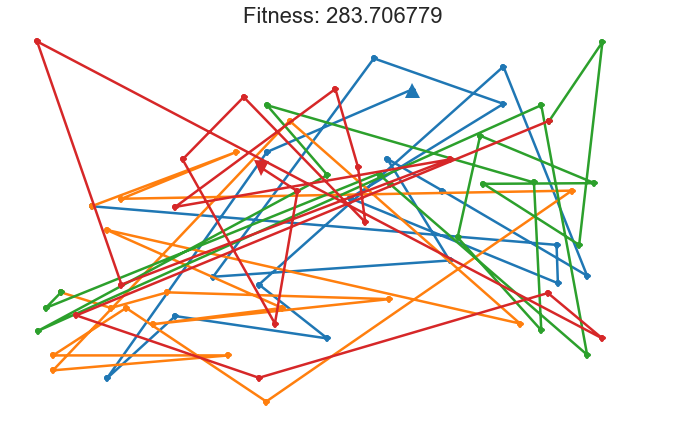

Generation 1000 best: 73.095626
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B1P5', 'B3P4', 'B2P2', 'B2P8', 'B3P11', 'B4P7', 'B2P9', 'B2P7', 'B5P7', 'B1P8', 'B1P3', 'B1P9', 'B4P5', 'B4P1', 'B5P2', 'B4P9', 'B4P6', 'B1P12', 'B4P11', 'B6P12', 'B5P11', 'B7P7', 'B6P1', 'B1P6', 'B1P10', 'B1P11', 'B7P1', 'B5P3', 'B2P3', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B1P2', 'B3P1', 'B7P3', 'B3P3', 'B1P1', 'B6P2', 'B2P10', 'B5P9', 'B4P8', 'B4P10', 'B2P12', 'B5P5', 'B3P9', 'B3P2', 'B2P11', 'B1P7', 'B5P8', 'B3P10', 'B5P4', 'B7P6', 'B3P6', 'B1P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B2P4', 'B6P11', 'B4P4', 'B5P10')


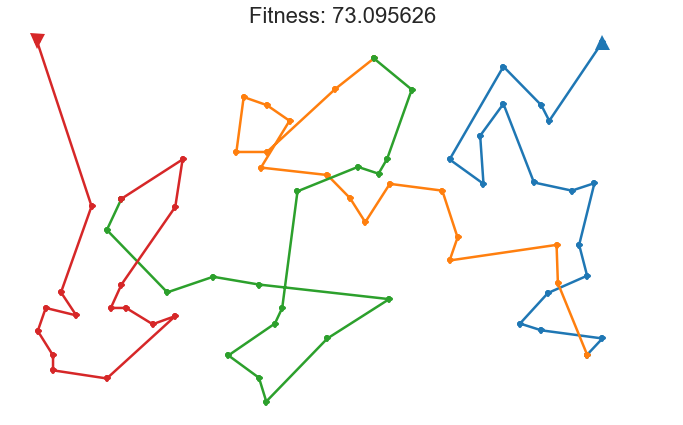

Generation 2000 best: 64.163757
('B5P1', 'B6P8', 'B7P2', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B2P7', 'B5P7', 'B5P2', 'B1P8', 'B1P3', 'B1P9', 'B4P1', 'B4P5', 'B4P9', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B7P7', 'B6P1', 'B3P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B3P10', 'B5P4', 'B7P6', 'B2P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


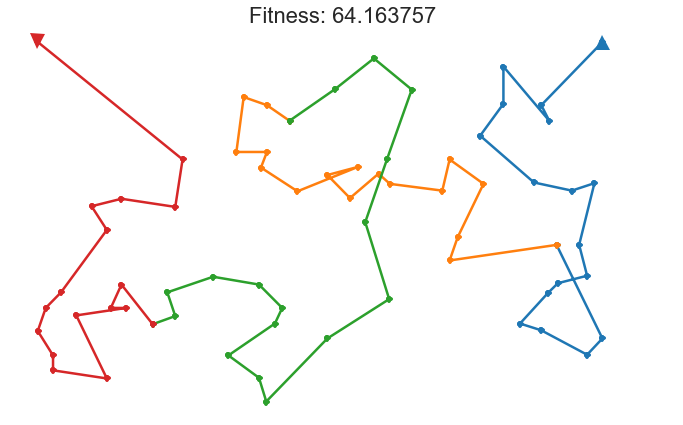

Generation 3000 best: 61.888180
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B2P7', 'B4P9', 'B5P2', 'B1P8', 'B1P3', 'B1P9', 'B4P1', 'B4P5', 'B5P7', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B1P2', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B7P6', 'B3P10', 'B5P4', 'B2P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


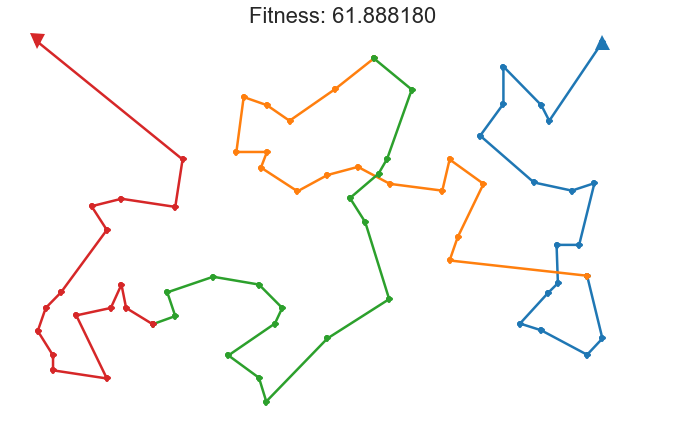

Generation 4000 best: 61.579230
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B2P7', 'B4P9', 'B5P7', 'B5P2', 'B1P8', 'B1P9', 'B4P1', 'B4P5', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B1P2', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B7P6', 'B3P10', 'B5P4', 'B2P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


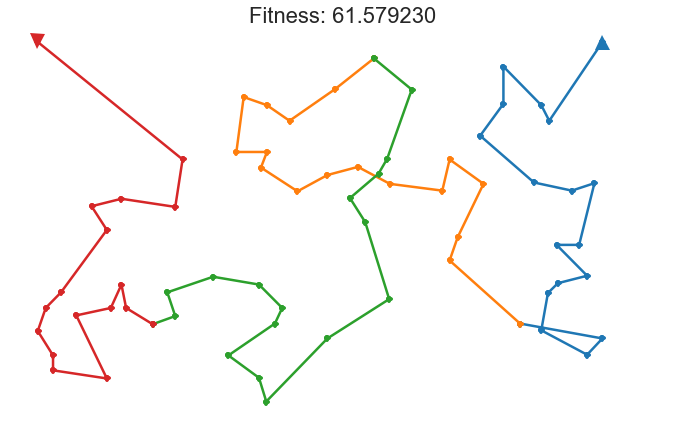

Generation 5000 best: 60.948624
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B2P7', 'B4P9', 'B1P8', 'B5P2', 'B5P7', 'B4P5', 'B4P1', 'B1P9', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B7P6', 'B3P10', 'B5P4', 'B2P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


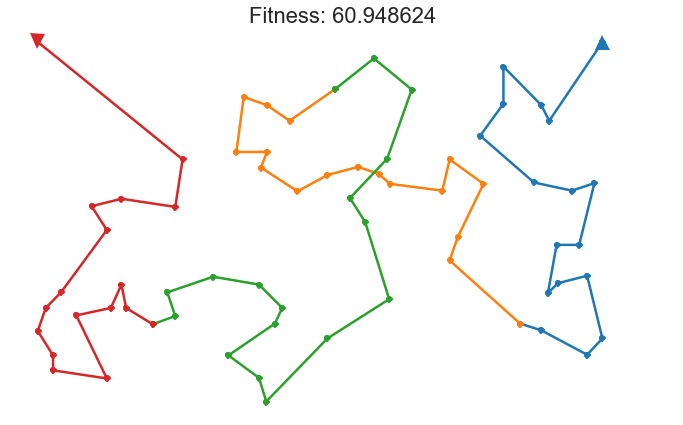

Generation 6000 best: 60.948624
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B2P7', 'B4P9', 'B1P8', 'B5P2', 'B5P7', 'B4P5', 'B4P1', 'B1P9', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B7P6', 'B3P10', 'B5P4', 'B2P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


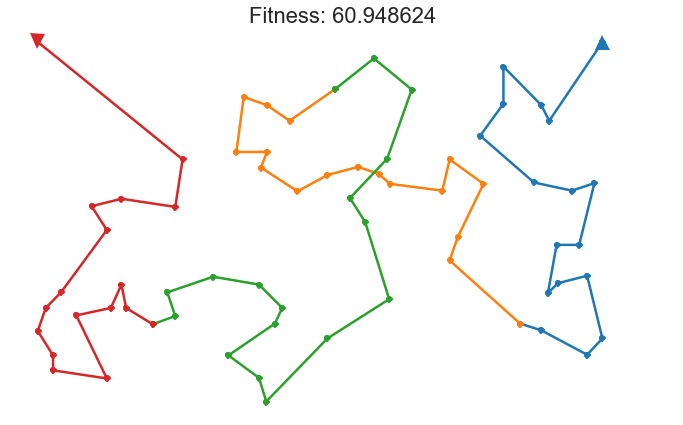

Generation 7000 best: 60.934271
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B4P9', 'B2P7', 'B5P7', 'B5P2', 'B1P8', 'B4P5', 'B4P1', 'B1P9', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B7P6', 'B3P10', 'B5P4', 'B2P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


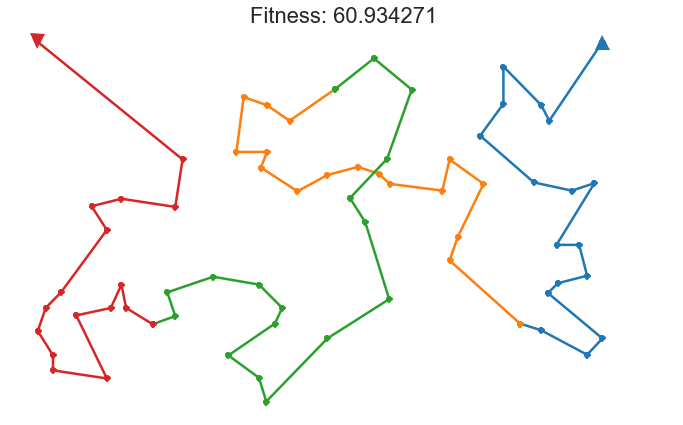

Generation 8000 best: 60.772526
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B4P9', 'B2P7', 'B5P7', 'B5P2', 'B1P8', 'B4P5', 'B4P1', 'B1P9', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B7P6', 'B5P4', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B2P4', 'B3P10', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


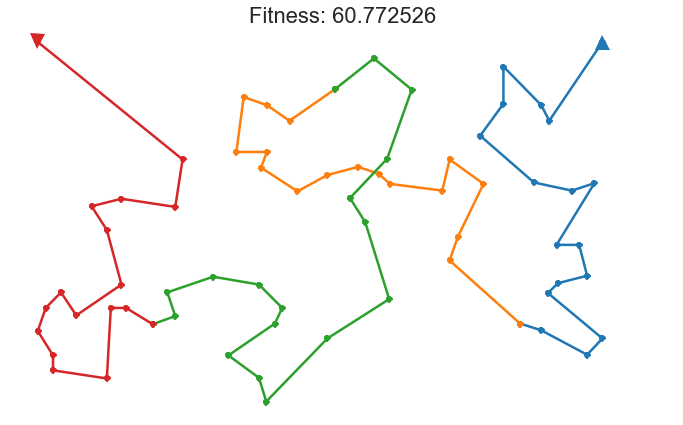

Generation 9000 best: 60.709435
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B2P9', 'B4P7', 'B4P9', 'B2P7', 'B5P7', 'B5P2', 'B1P8', 'B4P5', 'B4P1', 'B1P9', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B3P1', 'B6P1', 'B7P3', 'B1P6', 'B2P3', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B2P4', 'B7P6', 'B5P4', 'B3P10', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


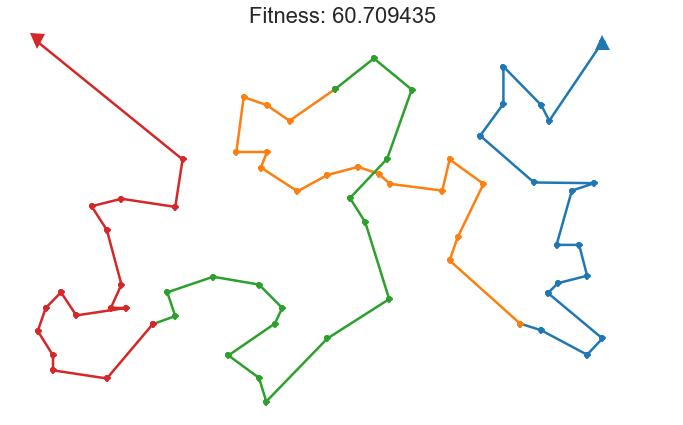

Generation 9999 best: 60.324768
('B5P1', 'B7P2', 'B6P8', 'B2P1', 'B2P8', 'B2P2', 'B3P11', 'B4P7', 'B2P9', 'B4P9', 'B2P7', 'B5P7', 'B5P2', 'B1P8', 'B4P5', 'B4P1', 'B1P9', 'B1P3', 'B4P6', 'B1P12', 'B3P4', 'B1P5', 'B4P11', 'B6P12', 'B1P2', 'B3P1', 'B6P1', 'B7P3', 'B2P3', 'B1P6', 'B5P3', 'B7P1', 'B1P11', 'B1P10', 'B3P5', 'B5P6', 'B3P8', 'B3P7', 'B7P7', 'B5P11', 'B4P10', 'B4P8', 'B5P9', 'B2P10', 'B6P2', 'B1P1', 'B3P3', 'B2P12', 'B5P5', 'B3P9', 'B1P4', 'B3P6', 'B4P3', 'B2P6', 'B2P5', 'B6P5', 'B4P2', 'B6P11', 'B2P4', 'B5P4', 'B7P6', 'B3P10', 'B3P2', 'B4P4', 'B2P11', 'B5P8', 'B1P7', 'B5P10')


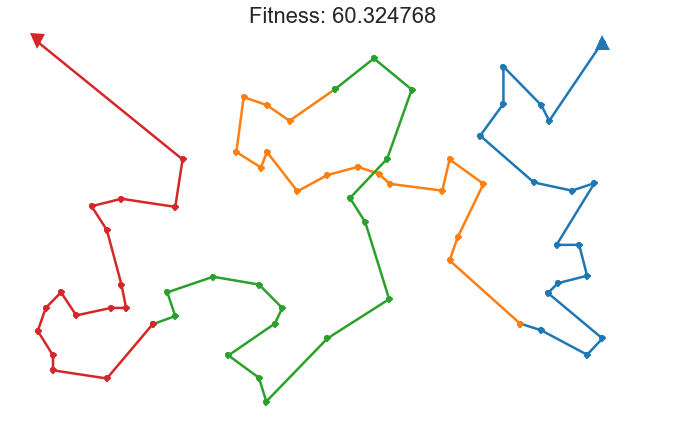

In [6]:
run_genetic_algorithm(generations=10000, population_size=100)

### Some notes on the methodology for the nerdy folk

Several people have pointed out that this method is very likely [overfit](http://en.wikipedia.org/wiki/Overfitting), i.e., that the path is trained so much on the 68 points that it likely wouldn't work well on a new 8th book. While this criticism is possibly true, it also misses the purpose of this project.

**The purpose of this project is to find an optimal search path for the first 7 'Where's Waldo?' books only.**

If the goal were to produce an optimal search path for any future books, it would become necessary to divide the 68 points into a training and testing set so some form of cross-validation could be performed. However, because the data is already quite sparse (68 points), this would likely prove to be a fruitless endeavor anyway.

That said, please feel free to continue working on this data set and discover better methods to find Waldo efficiently. I've provided the data set along with this notebook if you would like to work on it with your own methods.

If you find a better solution, please [contact me](http://www.randalolson.com/contact/) so I can take a look.